En este archivo puedes escribir lo que estimes conveniente. Te recomendamos detallar tu solución y todas las suposiciones que estás considerando. Aquí puedes ejecutar las funciones que definiste en los otros archivos de la carpeta src, medir el tiempo, memoria, etc.

## Reading Files

### Import Libraries

In [1]:
#! pip install -U memory_profiler

In [3]:
import json
import pandas as pd
import pyspark
import zipfile
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
%load_ext memory_profiler

### Converting zip to gz

In [68]:
%%bash
cd ../data
#unzip -p ../data/farmers-tweets.json.zip | gzip > farmers-tweets.json.gz
unzip -p ../data/farmers-protest-tweets-2021-2-4.json.zip | gzip > farmers-protest-tweets-2021-2-4.json.gz

### Reading tweets as pyspark object

Initially the data is a sample of tweets `./data/farmers-tweets.json`, afterwards we'll load the complete json file

In [85]:
namef = '../data/farmers-protest-tweets-2021-2-4'
#namef = 'farmers-tweets'

file_path = namef+'.json.gz'
print(f"** File to use: {file_path}")

** File to use: ../data/farmers-protest-tweets-2021-2-4.json.gz


The first test is perform the data loading over a RDD sprk object.
`%memit` magic cell allow us measure memory.

*Note: The spark.read.json is running in the .gz file

In [86]:
%memit
#Creating SparkSession 
spark = SparkSession.builder.appName('readJson').getOrCreate()
#Read file as pyspark object()   
data = spark.read.json(file_path)
#transformation and renaming columns steps
dfcol = data.withColumn("created_at", data["date"].cast('date'))\
                                .withColumn("user_id", data["user.id"])\
                                .withColumn("username", data["user.username"])

df = dfcol.select(col("created_at"), col("user_id"), col("username")).groupBy("created_at", "username").count()
df.sort(df["count"].desc()).show(10) 

peak memory: 1198.84 MiB, increment: 0.22 MiB


+----------+---------------+-----+
|created_at|       username|count|
+----------+---------------+-----+
|2021-02-19|       Preetm91|  267|
|2021-02-18|neetuanjle_nitu|  195|
|2021-02-17| RaaJVinderkaur|  185|
|2021-02-13|MaanDee08215437|  178|
|2021-02-12|RanbirS00614606|  176|
|2021-02-21|     Surrypuria|  161|
|2021-02-18|  rebelpacifist|  153|
|2021-02-19|KaurDosanjh1979|  138|
|2021-02-23|     Surrypuria|  135|
|2021-02-15|         jot__b|  134|
+----------+---------------+-----+
only showing top 10 rows



### Reading tweets as pandas df

In [77]:
#file_path = "../data/farmers-tweets.json"
file_path = '../data/farmers-protest-tweets-2021-2-4.json'


In [78]:
#Read file with json.loads()   
data = [json.loads(line) for line in open(file_path, 'r')]
#convert to dataframe
df = pd.DataFrame(data)
#transformation and renaming columns steps
df["created_at"] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
#lambda functions to create new columns from user tag
df['username'] = df['user'].apply(lambda d: d['username'])
df['user_id'] = df['user'].apply(lambda d: d['id'])

dfres = df.groupby(['created_at','username'])['id'].count().reset_index(name="count").sort_values("count", ascending=False) 

print(dfres.head(10))

       created_at         username  count
35219  2021-02-19         Preetm91    267
33193  2021-02-18  neetuanjle_nitu    195
26577  2021-02-17   RaaJVinderkaur    185
7536   2021-02-13  MaanDee08215437    178
2740   2021-02-12  RanbirS00614606    176
42691  2021-02-21       Surrypuria    161
33396  2021-02-18    rebelpacifist    153
34733  2021-02-19  KaurDosanjh1979    138
48696  2021-02-23       Surrypuria    135
18540  2021-02-15           jot__b    134


## Memory Profiler

Track stdout memory consumption with `%mprun` magic command

### Spark function

In [82]:
from q1_memory import q1_memory
file_path = "../data/farmers-protest-tweets-2021-2-4.json.gz"
%mprun -f q1_memory q1_memory(file_path)

+----------+---------------+-----+
|created_at|       username|count|
+----------+---------------+-----+
|2021-02-19|       Preetm91|  267|
|2021-02-18|neetuanjle_nitu|  195|
|2021-02-17| RaaJVinderkaur|  185|
|2021-02-13|MaanDee08215437|  178|
|2021-02-12|RanbirS00614606|  176|
|2021-02-21|     Surrypuria|  161|
|2021-02-18|  rebelpacifist|  153|
|2021-02-19|KaurDosanjh1979|  138|
|2021-02-23|     Surrypuria|  135|
|2021-02-15|         jot__b|  134|
+----------+---------------+-----+
only showing top 10 rows




Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     9    123.7 MiB    123.7 MiB           1   def q1_memory(file_path: str) -> List[Tuple[datetime.date, str]]:
    10                                             
    11                                             #Creating SparkSession 
    12    123.7 MiB      0.0 MiB           1       spark = SparkSession.builder.appName('readJson').getOrCreate()
    13                                             #Read file as pyspark object()   
    14    123.7 MiB      0.0 MiB           1       data = spark.read.json(file_path)    
    15                                             #transformation and renaming columns steps
    16    123.7 MiB      0.0 MiB           2       dfcol = data.withColumn("created_at", data["date"].cast('date'))\
    17    123.7 MiB      0.0 MiB           1                                   .withColumn("user_id", data["user.id"])\
 

### Pandas Function

In [83]:
from q1_time import q1_time
file_path = "../data/farmers-protest-tweets-2021-2-4.json"
%mprun -f q1_time q1_time(file_path)

       created_at         username  count
35219  2021-02-19         Preetm91    267
33193  2021-02-18  neetuanjle_nitu    195
26577  2021-02-17   RaaJVinderkaur    185
7536   2021-02-13  MaanDee08215437    178
2740   2021-02-12  RanbirS00614606    176
42691  2021-02-21       Surrypuria    161
33396  2021-02-18    rebelpacifist    153
34733  2021-02-19  KaurDosanjh1979    138
48696  2021-02-23       Surrypuria    135
18540  2021-02-15           jot__b    134



Filename: /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    10    123.9 MiB    123.9 MiB           1   def q1_time(file_path: str) -> List[Tuple[datetime.date, str]]:
    11                                             
    12                                             #Read file with json.loads()   
    13   2263.2 MiB -499104.4 MiB      117410       data = [json.loads(line) for line in open(file_path, 'r')]
    14                                             #convert to dataframe
    15   2349.5 MiB     86.3 MiB           1       df = pd.DataFrame(data)
    16                                             #transformation and renaming columns steps
    17   2359.0 MiB      9.6 MiB           1       df["created_at"] = pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')
    18   2359.0 MiB -2460732.0 MiB      234815       df['username'] = df['user'].apply(lambda d: d['username'])
    19   2298.9 MiB    -60.2 M

### Generating memory usage reports with `mprof` and `plot`

### Spark Function

In [88]:
%%bash
echo mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py

mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_memory.py


![Screenshot 2024-03-15 at 7.12.03 PM.png](<attachment:Screenshot 2024-03-15 at 7.12.03 PM.png>)
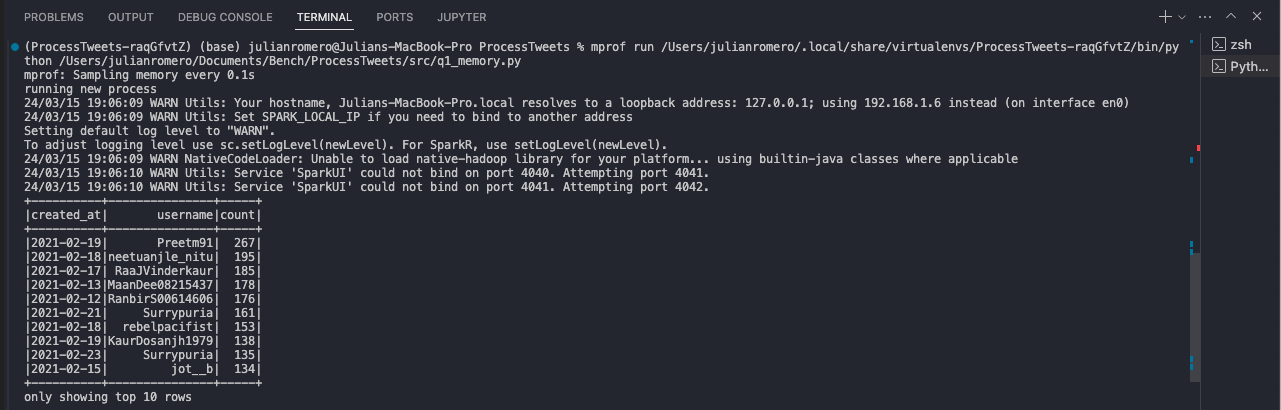

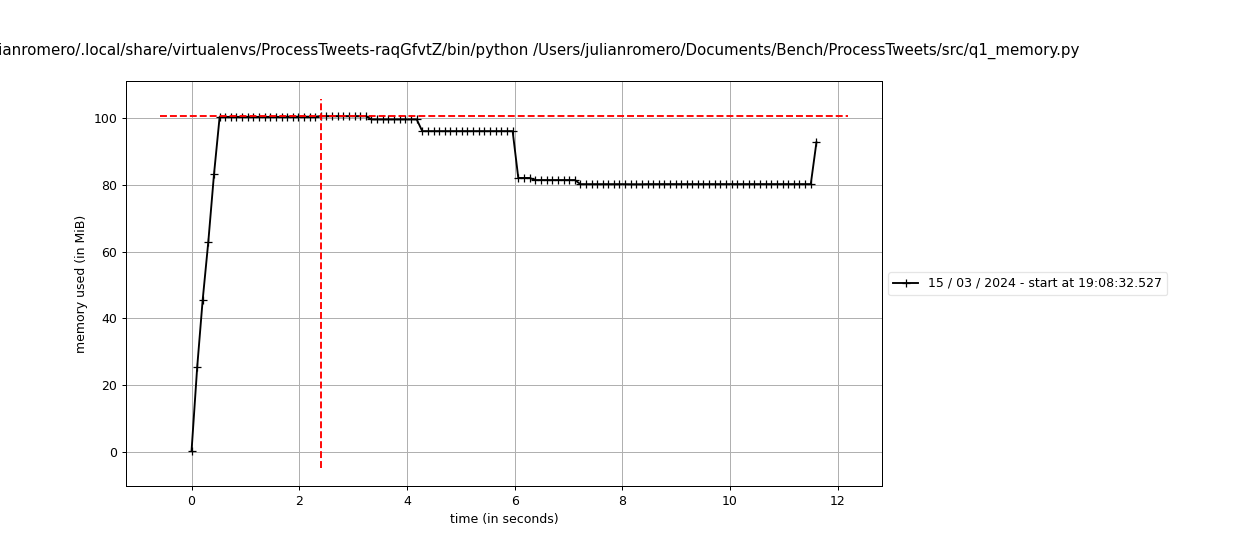

### Pandas Function

In [89]:
%%bash
echo mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py

mprof run /Users/julianromero/.local/share/virtualenvs/ProcessTweets-raqGfvtZ/bin/python /Users/julianromero/Documents/Bench/ProcessTweets/src/q1_time.py


![Screenshot 2024-03-15 at 7.22.52 PM.png](<attachment:Screenshot 2024-03-15 at 7.22.52 PM.png>)
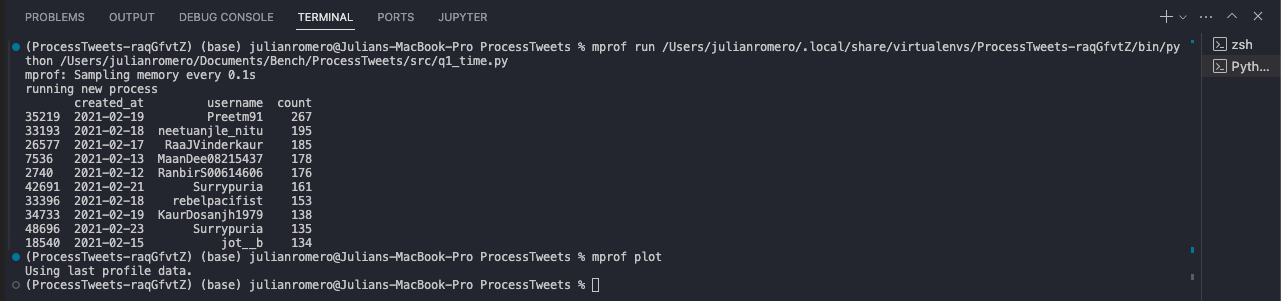

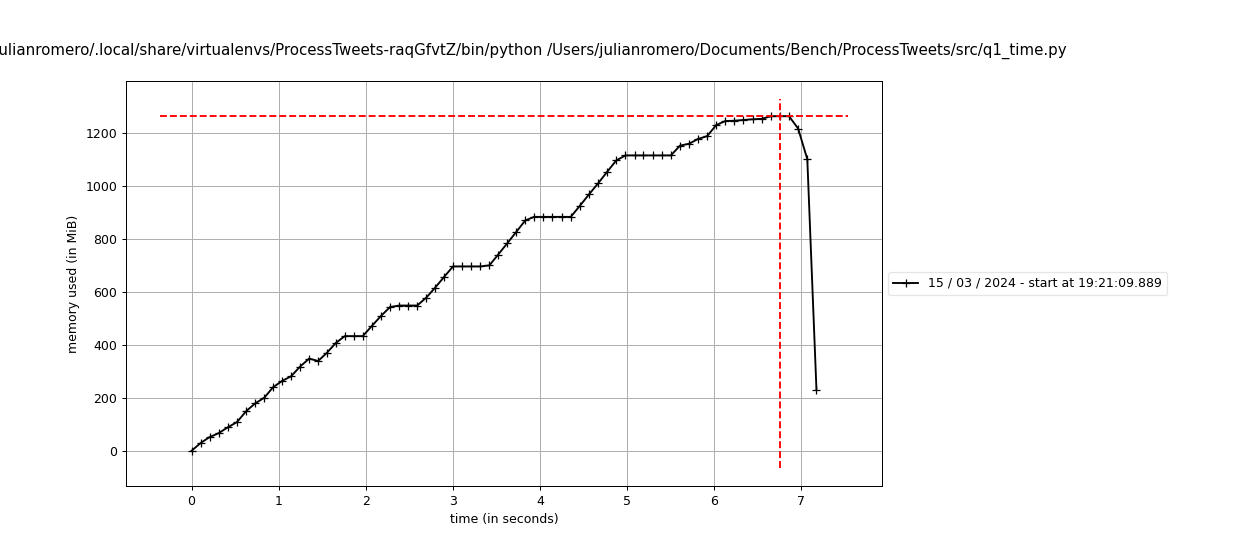